In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rnd
from scipy.ndimage import convolve
from tqdm import tqdm

class lightningSimulation:

    def __init__(self,
                 N = 40,
                 dimensions=None,
                 nu=1.5,
                 rod_height=0,
                 rod_xpos=0.5,
                 debug=False,
                 threshold = 0.0001,
                 neighborhood_type = ''):

        # Unless specified, expect grid of NxNxN dimension, in order x, y, z
        if dimensions is None:
            self.dim = np.array([N, N, N])
        else:
            self.dim = np.array(dimensions)

        # Create encoding grid and set all to 0
        #  0 encodes unfixed potential
        #  1 encodes fixed potential
        self.fixed_grid = np.zeros(shape=self.dim)

        # The electric potential
        self.potential = np.zeros(shape=self.dim)

        # The lightning downwards-tendency parameter
        self.nu = nu

        # Number of update steps
        self.steps = 0

        # To debug or not
        self.debug = debug
        self.display_interval = 75


        # Lightning distance to ground
        self.dist_to_ground = self.height

        self.struck_ground = False

        self.threshold = threshold

        self.difference_per_conv = []
        self.overall_sum = []

        # Neighborhood types
        diagonal_neighbors = [(1, 1), (-1, 1), (1, -1), (-1, -1)]
        neumann_neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1)]
        moore_neighbors = diagonal_neighbors.copy()
        moore_neighbors.extend(neumann_neighbors)

        if neighborhood_type == 'diagonal':
            self.neighborhood_type = diagonal_neighbors
        elif neighborhood_type == 'moore':
            self.neighborhood_type = moore_neighbors
        elif neighborhood_type == 'neumann':
            self.neighborhood_type = neumann_neighbors
        else:
            self.neighborhood_type = neumann_neighbors

        self.initial_electric_pot()

        self.setup_environment(rod_height, rod_xpos)


    def setup_environment(self, rod_height=0, rod_xpos=0.5):
        '''
        Creates the enviroment of
            1. lightning start position, where self.grid == 0
            2. cells which are considered ground, where self.grid == 1
        Unkown electric potential is where self.grid == -1
        '''

        # Potential of 1 represents ground
        # Set ground to potential 1
        self.fixed_grid[-1, :] = 1
        for i in range(rod_height):
            self.fixed_grid[-1-i, int(self.width*rod_xpos)] = 1

        # Potential of 0 represents current
        self.fixed_grid[0, self.width//2] = 0
        self.newest_neighbor = (0, int(self.width*rod_xpos))

        self.update_electric_pot(self.newest_neighbor)



    def display_state(self, this_grid=None, lightning=False):
        # Plot a figure displaying the environment
        if this_grid is None:
            this_grid = self.fixed_grid

        # If display lightning
        if lightning:
            # Display 0 potentials as yellow
            masked_arr = np.ma.masked_where(this_grid == 0, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='yellow')
        else:
            # Otherwise it's plotting potential
            # Otherwise set -1 as gray
            masked_arr = np.ma.masked_where(this_grid == -1, this_grid)
            cmap = matplotlib.cm.viridis
            cmap.set_bad(color='gray')

        # Display
        plt.figure(figsize=(16, 10))
        plt.imshow(masked_arr, cmap=cmap)
        plt.colorbar()

        if not lightning:
            plt.contour(this_grid, colors='white')
        plt.show()

    def strike_lightning(self):

        # Run update until lightning strikes ground
        self.struck_ground = False

        # Create a tqdm tracker
        if self.debug:
            progress_bar = tqdm(total=self.height, desc="How close the lightning is to the ground", unit="cells")

        while not self.struck_ground:
            # Update lightning
            self.update()

            if self.debug:
                # If the newly added cell made the lightning stretch one step lower, update dist_to_ground
                if self.height - self.newest_neighbor[0] < self.dist_to_ground:
                    self.dist_to_ground = self.height - self.newest_neighbor[0]
                    progress_bar.update(1)

    def check_struck_ground(self):
        # Look at all neighbors of newest neighbor
        for dy, dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            if self.newest_neighbor[0] > 5:
                # If within bounds
                if self.newest_neighbor[0]+dy > 0 and self.newest_neighbor[0]+dy < self.height and self.newest_neighbor[1]+dx > 0 and self.newest_neighbor[1]+dx < self.width:
                    # If one neighbor is ground (potential 1), break while loop
                    if self.grid[self.newest_neighbor[0]+dy, self.newest_neighbor[1]+dx] == 1:
                        self.struck_ground = True

    def update(self):

        # Debug
        if self.debug and self.steps % self.display_interval == 0:
            print("The lightning structure")
            self.display_state(lightning=True)

        # Keep track of neighbors
        neighbors = {}
        # For each cell
        for x in range(self.width):
            for y in range(self.height):
                # If this cell is part of the lightning structure
                if self.grid[y, x] == 0:
                    # For each neighbor
                    for dy, dx in self.neighborhood_type:
                        # If neighbor is within bounds
                        if y+dy >= 0 and y+dy < self.height and x+dx >= 0 and x+dx < self.width:
                            # If neighbor hasn't been counted before and it's not a part of the lightning
                            if (y+dy, x+dx) not in neighbors.keys() and self.fixed_grid[y+dy, x+dx] != 0:
                                # Add their electric potential to dictionary
                                neighbors[(y+dy, x+dx)] = self.potential[y+dy, x+dx]



        # Raise each weight to the power of n
        weights = [val**self.nu for val in neighbors.values()]
        # Ensure they sum up to 1
        #weights = np.array(weights)/np.sum(weights)
        # Choose a random neighbor with the weighting
        chosen_cell = rnd.choices(list(neighbors.keys()), weights)[0]

        # Update lightning grid, potential and newest neighbor
        self.newest_neighbor = chosen_cell

        self.update_electric_pot(self.newest_neighbor)

        self.check_struck_ground()

        self.steps += 1


    def initial_electric_pot(self):
        gradient = np.linspace(1/self.height, 1, self.height)

        # Reshape the gradient to match the dimensions of the array
        gradient = gradient[:, np.newaxis]

        # Tile the gradient to match the width of the array
        gradient = np.tile(gradient, (1, self.width))

        self.potential = gradient


    def update_electric_pot(self, pos):
        '''
        Calculates the unknown electric potential in the air
        by estimating the discrete solution to the 2D laplace
        equation (∇^2f = 0), which corresponds to the partial
        second derivatives being 0 everywhere. Intuitively it
        means that the electric potential changes smoothly everywhere.

        This is approximated by repeating diffusion over the grid,
        using a von Neumann kernel.
        '''

        # Remove the potential
        self.potential[pos[0], pos[1]] = 0

        # Set it as a fixed cell
        self.fixed_grid[pos[0], pos[1]] = 0

        # Update the rest of the potential
        self.potential = self.iterative_diffusion()



    def iterative_diffusion(self):

        # Kernel I perform convolutions with, takes the average of von Neumann neighborhood
        kernel = np.array([[0,1/4,0],[1/4,0,1/4],[0,1/4,0]])


        old_diffused = self.potential
        old_diffused = np.pad(old_diffused, 1, mode='constant')

        # Make ground and lightning structure fixed
        no_change_mask = (np.pad(self.fixed_grid, 1, mode='constant') != -1)

        # Set newly padded sides of grid to the a linear increase
        # This emulates that the electric potential is uniform outside scope of grid
        old_diffused[:,0] = np.linspace(0, 1, self.height+2)
        old_diffused[:,-1] = np.linspace(0, 1, self.height+2)

        # Set unknown potentials, to update, to zero
        old_diffused[old_diffused == -1] = 0

        while True:

          # Convolve over entire grid
          diffused_grid = convolve(old_diffused, kernel, mode='constant', cval=1.0)

          # Reset the cells that shouldn't change
          diffused_grid[no_change_mask] = old_diffused[no_change_mask]


          self.difference_per_conv.append(np.sum(abs(np.array(diffused_grid) - np.array(old_diffused))))
          self.overall_sum.append(np.sum(np.array(diffused_grid)))

          if np.sum(abs(np.array(diffused_grid) - np.array(old_diffused))) < self.threshold:
            break

          old_diffused = diffused_grid

        # Remove padding
        diffused_grid = diffused_grid[1:-1,1:-1]

        if self.steps % self.display_interval == 0 and self.debug:
            print("The diffusion")
            self.display_state(self.potential)

        return diffused_grid

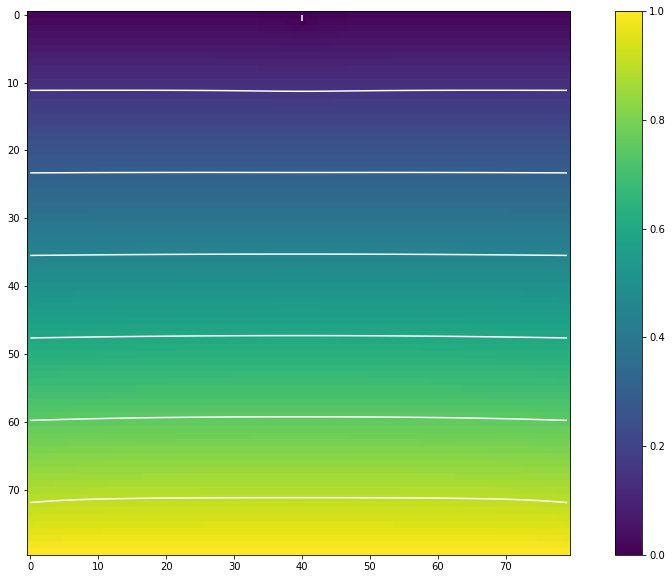

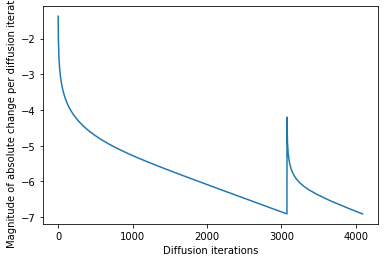

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.34it/s]


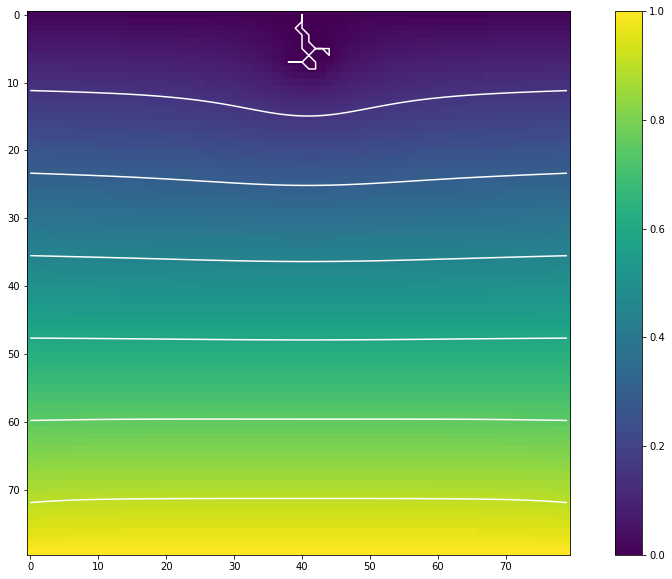

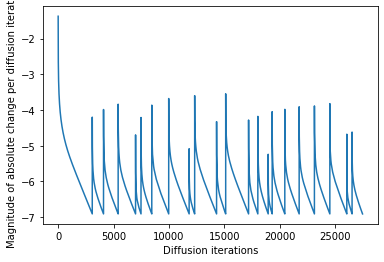

In [4]:
rnd.seed(10)
sim_instance = lightningSimulation(width=80, height=80, n=1.5, threshold=0.001)

sim_instance.update()
sim_instance.display_state(sim_instance.potential)
plt.plot(np.log(sim_instance.difference_per_conv))
plt.xlabel("Diffusion iterations")
plt.ylabel("Magnitude of absolute change per diffusion iteration")
plt.show()

for _ in tqdm(range(20)):
  sim_instance.update()

sim_instance.display_state(sim_instance.potential)
plt.plot(np.log(sim_instance.difference_per_conv))
plt.xlabel("Diffusion iterations")
plt.ylabel("Magnitude of absolute change per diffusion iteration")

plt.show()

prev_difference_per_conv = sim_instance.difference_per_conv[:]